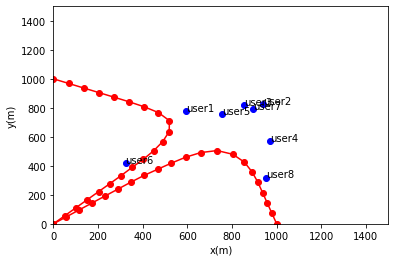

In [1]:
import decimal
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
a = 9.61
b = 0.15
nLOS = 1.12202
nNLOS = 10

c = 3*10**8#m/s
U = 8
N = 21
M = 2
D = 120#Mbit
h_uav = 50 #m
f_uav_max = 10#GHz
f_user_max = 1#GHz
B = 4#MHz
fc = 2*10**(9)#Hz
N0 = 10**(-11)#
C = 1#cycles/bit
k0 = 10**(-1)
v_max = 15#m/s
p_max = 0.6 #W
W = 10#kg
gamma = 10**(-4)
w_uav = 0.2
w_user = 0.8
tao = 5#s
epsilon = 1
alpha = 2
xishu = (4*np.pi*fc/c)**alpha#
J = np.log(2)/(B*tao)
def solveSP1(pre_x,f_uav,f_user,x,L_bar_im_n):
    Constrain_1 = []
    for n in range(N):
        Constrain_1.append(f_user[n]<=f_user_max)
        Constrain_1.append(f_user[n] >= 0)
    Constrain_2 = []
    for n in range(N):
        Constrain_2.append(f_uav[n] >= 0)
        Constrain_2.append(x[n] >= 0)
        Constrain_2.append(cp.sum(f_uav[n],axis=0)<=f_uav_max)
    Constrain_3 = []
    rk = [np.argsort(1/L_bar_im_n[n],axis=0) for n in range(N)]
    k = [np.argsort(rk[n],axis=0) for n in range(N)]
    for n in range(N):
        for i in range(U):
            out = 0
            mask = k[n][i,:]>0
            if np.all(mask):
                out+=cp.sum(cp.multiply(L_bar_im_n[n][i,mask],(cp.exp(J*x[n][k[n][i,mask],mask])-
                                            (cp.exp(J*pre_x[n][k[n][i,mask]-1,mask])+J*cp.multiply(cp.exp(J*pre_x[n][k[n][i,mask]-1,mask]),(x[n][k[n][i,mask]-1,mask]-pre_x[n][k[n][i,mask]-1,mask])))\
                                            )))
            elif np.all(~mask):
                out +=  cp.sum(cp.multiply(L_bar_im_n[n][i,~mask] , (cp.exp(J * x[n][k[n][i,~mask], ~mask])-1)))
            else:
                out+=cp.sum(cp.multiply(L_bar_im_n[n][i,mask],(cp.exp(J*x[n][k[n][i,mask],mask])-
                                            (cp.exp(J*pre_x[n][k[n][i,mask]-1,mask])+J*cp.multiply(cp.exp(J*pre_x[n][k[n][i,mask]-1,mask]),(x[n][k[n][i,mask]-1,mask]-pre_x[n][k[n][i,mask]-1,mask])))\
                                            )))
                out +=  cp.sum(cp.multiply(L_bar_im_n[n][i,~mask] , (cp.exp(J * x[n][k[n][i,~mask], ~mask])-1)))
            Constrain_3.extend(
                [out<= p_max/(B*N0)])

    Constrain_4 = []
    
    for i in range(U):
        out = 0
        for n in range(N):
            out+=f_user[n][i] * tao / C
            out+= cp.sum(f_uav[n][i,:] * tao / C)
        Constrain_4.append(out>=D)
    Constrain_5 = []
    
    for i in range(U):
        for m in range(M):
            out = 0
            cons = 0
            for n in range(N):
                cons=cons + f_uav[n][i,m]*tao/C
                if n!=N-1:
                    if k[n][i,m]>0:
                        out  += x[n][k[n][i,m],m]-x[n][k[n][i,m]-1,m]
                    else:
                        out += x[n][k[n][i,m],m]
                Constrain_5.append(out>=cons)
    Constrain_6 = []
    for n in range(N):
        Constrain_6.append(x[n][1:,:]>=x[n][:-1,:])
        Constrain_6.append(x[n]>=0)
    
    beta = np.array([[[L_bar_im_n[n][rk[n][k,m],m]*B*N0 for m in range(M)]for k in range(U)] for n in range(N)])
    obj = 0
    for n in range(N):
        obj = obj + w_user*k0*cp.sum(cp.power(f_user[n],3)*tao)
        obj = obj + w_uav * k0*cp.sum(cp.power(f_uav[n],3)*tao)
        for i in range(U):
            mask = k[n][i,:]+1<U
            if np.all(mask):
                obj= obj + cp.sum(w_user*cp.multiply((beta[n][k[n][i,mask],mask]-beta[n][k[n][i,mask]+1, mask]),cp.exp(J*x[n][k[n][i,mask],mask])))
            elif np.all(~mask):
                obj = obj + cp.sum(w_user*cp.multiply(beta[n][k[n][i,~mask],~mask],cp.exp(J*x[n][k[n][i,~mask],~mask])))
                obj = obj - cp.sum(w_user*beta[n][0,~mask])
            else:
                obj= obj + cp.sum(w_user*cp.multiply((beta[n][k[n][i,mask],mask]-beta[n][k[n][i,mask]+1, mask]),cp.exp(J*x[n][k[n][i,mask],mask])))
                obj = obj + cp.sum(w_user*cp.multiply(beta[n][k[n][i,~mask],~mask],cp.exp(J*x[n][k[n][i,~mask],~mask])))
                obj = obj - cp.sum(w_user*beta[n][0,~mask])
    constrains = Constrain_1+Constrain_2+Constrain_3+Constrain_4+Constrain_5+Constrain_6
    prob = cp.Problem(cp.Minimize(obj),constrains)
    prob.solve(solver="MOSEK",warm_start=True,verbose=False)
    return obj.value
def solveSP2(x,r_user,pre_r_uav):
    def ka(i,n,m):
        if i>0:
            tmp = float(np.exp(J*x[n][i,m])-np.exp(J*x[n][i-1,m]))
            # assert tmp>=0,"error, get ka: "+str(tmp)
            return max(tmp,0)
        else:
            tmp = float(np.exp(J*max(0,x[n][i,m]))-1)
            # assert tmp>=0,"error, get ka: "+str(tmp)
            return max(tmp,0)
    r_uav = [cp.Variable((M,2)) for i in range(N)]
    pre_r_uav = np.array(pre_r_uav)
    r_user = np.array(r_user)
    r_user1 = r_user.reshape((1,U,1,2))
    pre_r_uav1 = pre_r_uav.reshape((N,1,M,2))
    
    for i in range(N):
        r_uav[i].value = pre_r_uav[i]
    d_im_n = []
    for n in range(N):
        d_im = []
        for i in range(U):
            d_im.append([])
            for m in range(M):
                d_im[i].append(cp.norm(cp.hstack([(r_uav[n][m,0]-r_user[i][0]),(r_uav[n][m,1]-r_user[i][1]),h_uav]),2))
        d_im_n.append(d_im)
    d_im_n1 = np.sqrt(np.sum((r_user1-pre_r_uav1)**2,axis=-1)+h_uav**2)
    theta_im_n = 180 / np.pi * np.arcsin(h_uav / d_im_n1)
    L_LOS_im_n = nLOS * xishu *d_im_n1**(alpha)
    L_NLOS_im_n = nNLOS * xishu *d_im_n1**(alpha)
    pLOS_im_n = 1 / (1 + a * np.exp(-b * (theta_im_n - a)))
    L_bar_im_n = pLOS_im_n * L_LOS_im_n + (1 - pLOS_im_n) * L_NLOS_im_n
    g_im_n = 1/L_bar_im_n
    rk = np.argsort(g_im_n,axis=1)
    # flat_list = [item.value for sublist1 in d_im_n for sublist2 in sublist1 for item in sublist2]
    p1 = cp.Variable(1, nonneg=True)
    p2 = cp.Variable(1,nonneg=True)
    p3 = cp.Variable(1)
    newobj = 0
    y = B*N0*L_bar_im_n
    newobj = cp.norm(p1*d_im_n1.flatten()**2+p2*d_im_n1.flatten()+p3-y.flatten())
    cp.Problem(cp.Minimize(newobj)).solve(solver=cp.MOSEK,verbose=False)
    coef = (float(p1.value),float(p2.value),float(p3.value))
    obj = 0
    for n in range(N):
        if n >0:
            obj = obj + w_uav*gamma*W/tao/2*cp.sum(cp.square(r_uav[n]-r_uav[n-1]))
        for i in range(U):
            for m in range(M):
                obj = obj + tao*w_user*ka(i,n,m)*(coef[0]*(d_im_n[n][rk[n,i,m]][m])**2+coef[1]*d_im_n[n][rk[n,i,m]][m]+coef[2])
    Constrain_6 = []
    for n in range(N):
        if n>0:
            Constrain_6.append(cp.norm(r_uav[n] - r_uav[n - 1],axis=1)<=(v_max*tao))
    Constrain_7 = []
    Constrain_7.append(r_uav[0]==pre_r_uav[0])
    Constrain_7.append(r_uav[N-1]==pre_r_uav[N-1])
    constrains = Constrain_6+Constrain_7
    prob = cp.Problem(cp.Minimize(obj), constrains)
    prob.solve(solver="MOSEK",warm_start=True,verbose=False)
    r_uav_output = [r_uav[i].value for i in range(N)]
    return r_uav_output
def algorithm1(r_user,r_uav,pre_x=None,is_return_var=False,isone_iteration=False):
    f_uav = [cp.Variable((U, M)) for i in range(N)]
    f_user = [cp.Variable(U) for i in range(N)]
    x = [cp.Variable((U, M)) for i in range(N)]
    d_im_n = []
    theta_im_n = []
    for n in range(N):
        d_im = np.zeros((U, M), dtype=np.float64)
        d_im = np.sqrt(
            np.sum(np.square(r_user.reshape(-1,1,2) - r_uav[n].reshape(1,-1,2)),axis=-1)+h_uav**2)
        theta_im = 180 / np.pi * np.arcsin(h_uav / d_im)
        theta_im_n.append(theta_im)
        d_im_n.append(d_im)
    pLOS_im_n = [1 / (1 + a * np.exp(-b * (theta_im_n[i] - a))) for i in range(N)]
    L_LOS_im_n = [nLOS * xishu * (d_im_n[i] )**(alpha) for i in range(N)]
    L_NLOS_im_n = [nNLOS * xishu  * (d_im_n[i])**(alpha) for i in range(N)]
    L_bar_im_n = [pLOS_im_n[i] * L_LOS_im_n[i] + (1 - pLOS_im_n[i]) * L_NLOS_im_n[i] for i in range(N)]
    g_im_n = [1 / L_bar_im_n[i] for i in range(N)]
    pre_val = 0
    if pre_x is None:
        pre_x = np.zeros((N,U,M),dtype=np.float64)
    while abs((val:=solveSP1(pre_x,f_uav,f_user,x,L_bar_im_n))-pre_val)>=epsilon:
        pre_val = val
        pre_x = [x[i].value for i in range(N)]
        if isone_iteration:
            break
    p = [np.zeros((U,M),dtype=np.float64) for i in range(N)]
    f_user_output = [f_user[i].value for i in range(N)]
    f_uav_output = [f_uav[i].value for i in range(N)]
    x_output = [x[i].value for i in range(N)]
    rk = np.argsort(np.array(g_im_n),axis=1)
    for i in range(U):
        for m in range(M):
            for n in range(N):
                if i>0:
                    p[n][rk[n,i,m],m] = B*N0/g_im_n[n][rk[n,i,m],m]*(np.exp(J*x_output[n][i,m])-np.exp(J*x_output[n][i-1,m]))
                else:
                    p[n][rk[n,i,m], m] = B * N0 / g_im_n[n][rk[n,i,m], m] * (np.exp(J * x_output[n][i, m])-1)
    if is_return_var:
        return p,f_user,f_uav,x
    else:
        return p,f_user_output,f_uav_output,x_output
def algorithm2(r_user,r_uav,max_iter=None):
    power,f_user_output,f_uav_output,x_output = algorithm1(r_user,r_uav)
    def compute_p(f_user,f_uav,power,r_uav):
        if isinstance(f_uav[0],cp.Variable):
            f_uav_val = [f_uav[i].value for i in range(N)]
            f_user_val = [f_user[i].value for i in range(N)]
            f_uav = f_uav_val
            f_user = f_user_val
        obj = 0
        for i in range(U):
            for n in range(N):
                obj += w_user * (f_user[n][i]) ** 3 * k0 * tao
                for m in range(M):
                    obj += w_user*power[n][i,m]*tao
                    obj += w_uav*(f_uav[n][i,m])**3*k0*tao
        for m in range(M):
            for n in range(N):
                if n>0:
                    obj+=w_uav*W/2/tao*gamma*np.sum((r_uav[n][m]-r_uav[n-1][m])**2)
        return obj
    p = compute_p(f_user_output,f_uav_output,power,r_uav)
    r_uav_output = solveSP2(x_output, r_user, r_uav)
    out_p = [p]
    i = 0
    pre_p = None
    while pre_p is None or (abs(p-pre_p)>=epsilon and max_iter is None) or (max_iter is not None and i<max_iter):
        pre_p = p
        r_uav_output = solveSP2(x_output,r_user,r_uav_output)
        power, f_user_output, f_uav_output, x_output = algorithm1(r_user, r_uav_output,x_output,isone_iteration=True)
        p = compute_p(f_user_output, f_uav_output, power, r_uav)
        i+=1
        out_p.append(p)
    return power,f_user_output,f_uav_output,r_uav_output,out_p

if __name__ == '__main__':
    start_point = np.array([[0,0],[0,0]],dtype=np.float64)
    end_point = np.array([[0,1000],[1000,0]],dtype=np.float64)
    r_uav = np.linspace(start_point,end_point,N)#(N,M,2)
    r_users = np.array([[596, 775], [941, 828], [854, 818], [971, 572], [757, 756], [323, 416], [895, 794], [953, 319]],
                     dtype=np.float64)
    p,f_user_output,f_uav_output,r_uav_output,out_p_user8 = algorithm2(r_users,r_uav)
    r_uav_output = np.array(r_uav_output)
    plt.scatter(r_users[:,0],r_users[:,1],color='b')
    for i in range(len(r_users)):
        plt.annotate("user"+str(i+1), xy = (r_users[i,0], r_users[i,1]), xytext = (r_users[i,0]-0.04, r_users[i,1]+0.03))
    for m in range(M):
        plt.scatter(r_uav_output[:,m,0],r_uav_output[:,m,1],color='r')
        plt.plot(r_uav_output[:,m,0],r_uav_output[:,m,1],color='r')
    plt.xlabel("x(m)")
    plt.ylabel("y(m)")
    plt.xlim(0,1500)
    plt.ylim(0,1500)

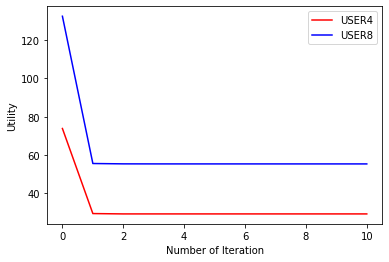

In [2]:
U = 4
_, _, _, _, out_p_user4 = algorithm2(r_users[:4], r_uav,max_iter=10)
U = 8
_, _, _, _, out_p_user8 = algorithm2(r_users, r_uav,max_iter=10)
fig, ax = plt.subplots()
ax.plot(list(range(len(out_p_user4))), out_p_user4, color='r',label="USER4")
ax.plot(list(range(len(out_p_user8))), out_p_user8, color='b',label="USER8")
ax.legend()
plt.xlabel("Number of Iteration")
plt.ylabel("Utility")
plt.show()

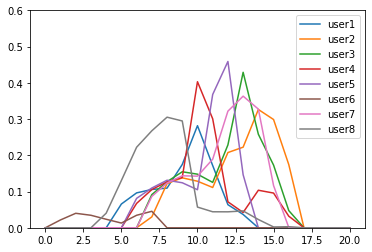

In [3]:
power_p = np.array(p)
power_p = np.sum(power_p,axis=-1)
for i in range(U):
    plt.plot(list(range(N)),power_p[:,i],label="user"+str(i+1))
plt.ylim(0,0.6)
plt.legend()
plt.show()